In [1]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn')

# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

1.1 Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value.

The linear regression without including a constant term suggests that for every point Federer makes his opponent will make 0.86 of a point. This indicates that Federer generally score more points than his opponents. The p-value is 0. Given that it is very small, it is possible to reject the null hypothesis the ${\beta}_{1}$ is equal to 0 and conclude that there is relationship between the number of points Federer and his opponents made. 

1.2 Should your regression include a constant term? Why or why not? 

It is possible to add a constant term. The fit seems to be overall better especially when total points won are beyond 150. However, by adding a constant term, the R² decreases from 0.969 to 0.794. Also, the constant term would be -10.1952 for this dataset. A negative value for the player 2 total points is hard to interpret in the context of tennis given that points should be equal or greater to 0. 


In [2]:
def create_model(y, X, feature, cov_type = False):
    y = y.copy()
    X = X.copy()

    x_var_name = feature
    y_var_name = y.columns[0]
    
    if cov_type:
         est = sm.OLS(y, X).fit(cov_type='HC2')          
    else:
        est = sm.OLS(y, X).fit()   
    
    xfit = np.array(X)
    yfit = est.predict(xfit[:, np.newaxis])
    
    #Graph
    fig, ax = plt.subplots()
    ax.scatter(X[x_var_name], y, alpha = 0.5)
    ax.scatter(X[x_var_name], yfit, color = 'red')
    plt.xlabel(x_var_name.title())
    plt.ylabel(y_var_name.title())
    plt.title(f'{y_var_name} vs. {x_var_name}'.title())
    plt.show()
    return est.summary()


In [3]:
df_tennis = pd.read_csv('data/tennis.csv')
df = df_tennis[['player1 total points won','player2 total points won']].dropna()

In [4]:
# Scenario 0 without constant term
X0 = df[['player1 total points won']]

# Scenario 1 with constant term
X1 = sm.add_constant(X0)

# Response
y = df[['player2 total points won']]

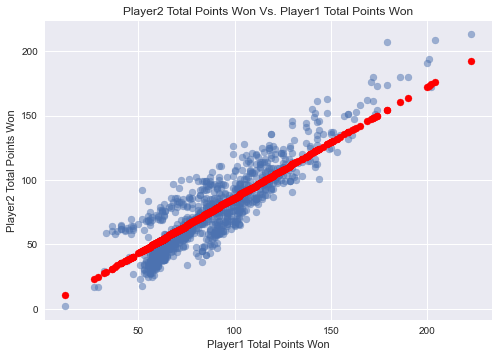

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     player2 total points won   R-squared (uncentered):                   0.969
Model:                                  OLS   Adj. R-squared (uncentered):              0.969
Method:                       Least Squares   F-statistic:                          3.196e+04
Date:                      Sat, 16 Jan 2021   Prob (F-statistic):                        0.00
Time:                              20:29:00   Log-Likelihood:                         -4173.8
No. Observations:                      1027   AIC:                                      8350.
Df Residuals:                          1026   BIC:                                      8355.
Df Model:                                 1                                                  
Covariance Type:                  nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
player1 total points won     0.8618      0.005    178.783      0.000       0.852       0.871
==============================================================================
Omnibus:                       70.330   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.878
Skew:                           0.698   Prob(JB):                     6.11e-19
Kurtosis:                       3.093   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
#Scenario 0
f = 'player1 total points won'
create_model(y, X0, f)

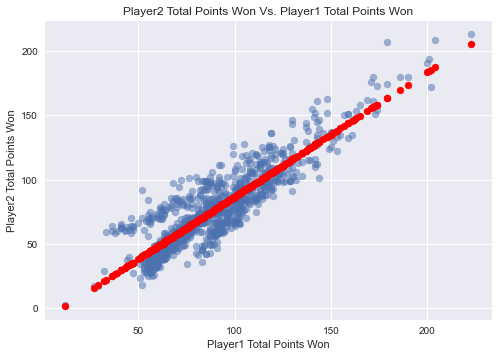

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player2 total points won   R-squared:                       0.794
Model:                                  OLS   Adj. R-squared:                  0.794
Method:                       Least Squares   F-statistic:                     3948.
Date:                      Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                              20:29:00   Log-Likelihood:                -4148.1
No. Observations:                      1027   AIC:                             8300.
Df Residuals:                          1025   BIC:                             8310.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -10.1952      1.406     -7.253      0.000     -12.954      -7.437
player1 total points won     0.9683      0.015     62.836      0.000       0.938       0.998
==============================================================================
Omnibus:                       82.506   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.773
Skew:                           0.744   Prob(JB):                     1.31e-22
Kurtosis:                       3.373   Cond. No.                         299.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
#Scenario 1
f = 'player1 total points won'
create_model(y, X1, f)

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


2.1

Is the relation between Top10perc and Top25perc best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

The relation between Top10perc and Top25perc is best fit using a model with a polynomial of degree 2. In this case, the additonal constant would decrease R². It would not be useful to add a constant term given that if there is there are not any Top 25 perc then there should not be any top 10 perc. By comparing the R², AIC and BIC between the models. Greater R squared closer to 1 would explain better proportion of variance explained by the model whereas a relative lower AIC and BIC can guide for model selection. (Scenario 1 to 3 below)

2.2

Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for Private. Explain your model specification choices.

Private schools do not have more admissions overall compared to nonprivate schools. The linear regression model suggests that private schools have around 2614 +/- 245 less admissions than nonprivate schools. Zeroes were used to represent nonprivate schools whereas ones represent private schools. A constant term was considered given the data for nonprivate schools indicate the constant term is different than 0.


In [7]:
#Question 2.1
#Scenario 1 top 10 perc vs. top25perc without constant term
#Scenario 2 top 10 perc vs. top25perc with constant term
#Scenario 3 top 10 perc vs. top25perc wth polynomial of degree 2

#Question 2.2
#Scenario 4 admission vs private schools

In [8]:
df_college = pd.read_csv('data/college.csv')
df1 = df_college[['Top10perc', 'Top25perc']].copy()


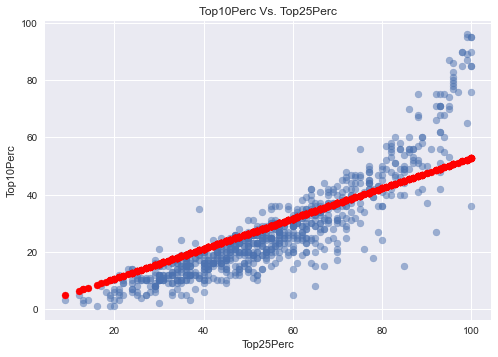

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Top10perc   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              7971.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                        0.00
Time:                        20:29:01   Log-Likelihood:                         -2871.5
No. Observations:                 777   AIC:                                      5745.
Df Residuals:                     776   BIC:                                      5750.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Top25perc      0.5275      0.006     89.281      0.000       0.516       0.539
==============================================================================
Omnibus:                      308.637   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1351.429
Skew:                           1.814   Prob(JB):                    3.47e-294
Kurtosis:                       8.346   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
#Scenario 1 top25perc without constant term
X1 = df1[['Top25perc']]
y = df1[['Top10perc']]
f = 'Top25perc'
create_model(y, X1, f)


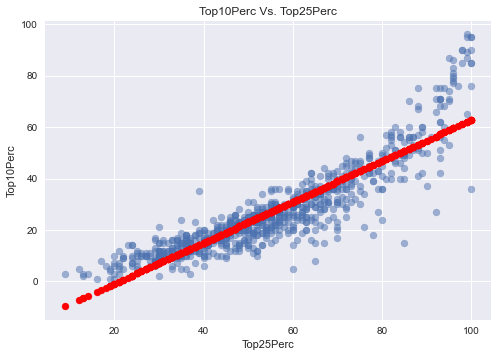

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Top10perc   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3018.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          1.87e-269
Time:                        20:29:01   Log-Likelihood:                -2715.2
No. Observations:                 777   AIC:                             5434.
Df Residuals:                     775   BIC:                             5444.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.7725      0.856    -19.588      0.000     -18.453     -15.092
Top25perc      0.7945      0.014     54.933      0.000       0.766       0.823
==============================================================================
Omnibus:                       85.585   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              395.735
Skew:                           0.383   Prob(JB):                     1.17e-86
Kurtosis:                       6.411   Cond. No.                         177.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
#scenario 2 top25perc with constant term
X2 = df1[['Top25perc']]
X2 = sm.add_constant(X2)
y = df1[['Top10perc']]
f = 'Top25perc'
create_model(y, X2, f)


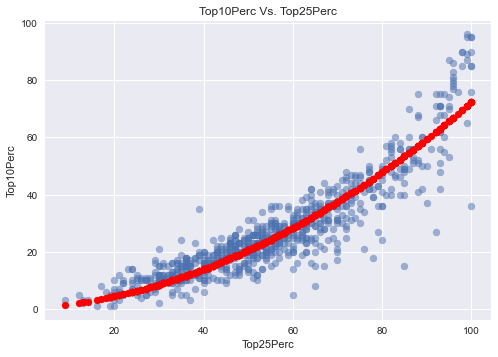

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Top10perc   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              8377.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):                        0.00
Time:                        18:12:37   Log-Likelihood:                         -2600.9
No. Observations:                 777   AIC:                                      5206.
Df Residuals:                     775   BIC:                                      5215.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Top25perc        0.0974      0.016      6.106      0.000       0.066       0.129
Top25perc_sq     0.0062      0.000     27.930      0.000       0.006       0.007
==============================================================================
Omnibus:                      149.322   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              749.525
Skew:                          -0.773   Prob(JB):                    1.75e-163
Kurtosis:                       7.557   Cond. No.                         273.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Scenario 3 top25perc wth polynomial of degree 2 without constant term
df1['Top25perc_sq'] =  df1['Top25perc'].apply(lambda X: X**2)
X3 = df1[['Top25perc', 'Top25perc_sq']]
y = df1[['Top10perc']]
f = 'Top25perc'
create_model(y, X3, f)

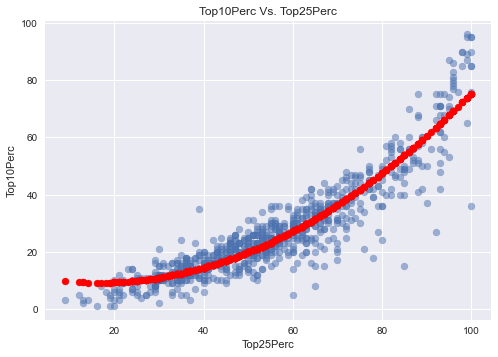

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Top10perc   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     2305.
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:12:40   Log-Likelihood:                -2578.5
No. Observations:                 777   AIC:                             5163.
Df Residuals:                     774   BIC:                             5177.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.7490      1.735      6.773      0.000       8.344      15.154
Top25perc       -0.3124      0.062     -5.002      0.000      -0.435      -0.190
Top25perc_sq     0.0095      0.001     18.066      0.000       0.008       0.011
==============================================================================
Omnibus:                      184.094   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.340
Skew:                          -0.970   Prob(JB):                    5.86e-208
Kurtosis:                       8.071   Cond. No.                     3.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Scenario 3.2 top25perc wth polynomial of degree 2 without constant term
df1['Top25perc_sq'] =  df1['Top25perc'].apply(lambda X: X**2)
X3 = df1[['Top25perc', 'Top25perc_sq']]
X3 = sm.add_constant(X3)
y = df1[['Top10perc']]
f = 'Top25perc'
create_model(y, X3, f)

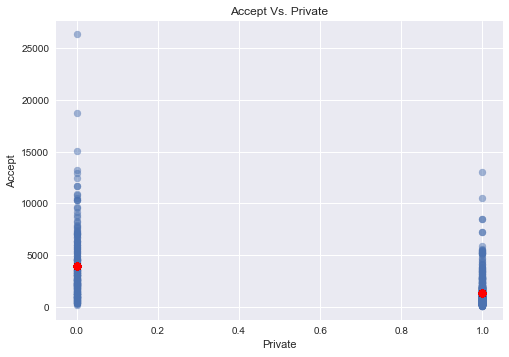

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Accept   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     113.2
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           9.15e-25
Time:                        20:29:01   Log-Likelihood:                -7066.5
No. Observations:                 777   AIC:                         1.414e+04
Df Residuals:                     775   BIC:                         1.415e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3919.2877    238.820     16.411      0.000    3451.210    4387.366
Private    -2613.5851    245.672    -10.639      0.000   -3095.093   -2132.077
==============================================================================
Omnibus:                      603.909   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15927.055
Skew:                           3.268   Prob(JB):                         0.00
Kurtosis:                      24.195   Cond. No.                         3.60
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [12]:
#Scenario 4 admission vs private schools 
df2 = df_college[['Private', 'Accept']].copy()
map_private = {'Yes': 1, 'No': 0}
df2['Private'] = df2['Private'].map(map_private)
f = 'Private'
X = df2[[f]]
X = sm.add_constant(X)
y = df2[['Accept']]

create_model(y, X, f, True)


# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
Given that the p-value is small, the null hypothesis can be rejected. This indicates that there is a relationship between the predictor and the response.
 
 
 ii. How strong is the relationship between the predictor and the response?
 
 The predictor explain almost 61 % of the variance in miles per gallon. 
 
 iii. Is the relationship between the predictor and the response positive or negative?
 
Since the coefficient associated to the predictor is negative, the relationship between the predictor and the response is negative. Therefore, as horsepower increases, the miles per gallon decreases. 
 
 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

Predicted mpg if horsepower is 98 : 24.454700000000003 mpg

95% confidence interval: 21.837 to 27.112000000000002 mpg

 v. Make a regression plot the response and the predictor.
 
 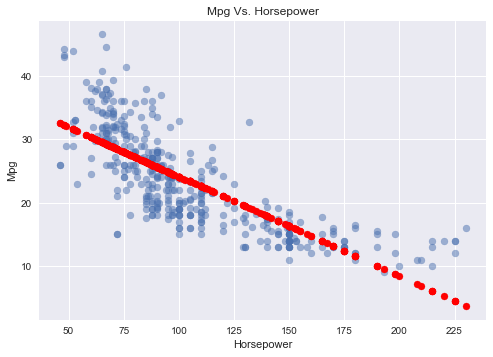

In [13]:
df_auto = pd.read_csv('data/auto.csv')

#cleaning data
cols = list(df_auto.columns)[0]
cols = cols.split(' ')
cols = [x.split('\t') for x in cols]
new_cols = cols[0]+cols[1]
df_auto = df_auto.rename(columns = {'mpg\tcylinders\tdisplacement\thorsepower weight\tacceleration\tyear\torigin\tname':'temp'})
df_auto = df_auto[1:-1].reset_index(drop=True)
df_auto = df_auto['temp'].str.split('\t', expand = True)
df_auto =df_auto.rename(columns = {1:8})
df_temp=df_auto[0].str.split(expand=True)
df_temp = df_temp[df_temp[3]!='?']
df_temp = df_temp.astype(float)
df_auto = pd.concat([df_temp, df_auto[8]], axis = 1)
cols_dict = dict(zip(list(df_auto.columns), new_cols))
df_auto = df_auto.rename(columns = cols_dict)
df_auto = df_auto.dropna().reset_index(drop=True)

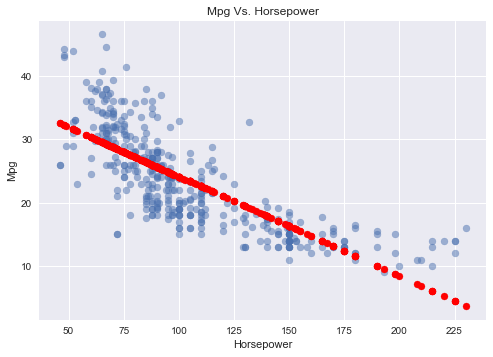

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     597.5
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           1.28e-80
Time:                        20:29:01   Log-Likelihood:                -1175.8
No. Observations:                 391   AIC:                             2356.
Df Residuals:                     389   BIC:                             2364.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9093      0.719     55.542      0.000      38.497      41.322
horsepower    -0.1577      0.006    -24.444      0.000      -0.170      -0.145
==============================================================================
Omnibus:                       16.793   Durbin-Watson:                   0.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.733
Skew:                           0.499   Prob(JB):                     0.000141
Kurtosis:                       3.305   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
df3 = df_auto[['mpg', 'horsepower']].copy()

f = 'horsepower'
X = df3[[f]]
X = sm.add_constant(X)
y = df3[['mpg']]


create_model(y, X, f)


In [15]:
#Horsepower associated with 98
horsepower = 98
predicted_mpg = -0.1577*horsepower+39.9093
lower_bound_2_5 = -0.170*horsepower+38.497
higher_bound_97_5 = -0.145*horsepower+41.322
print(f'predicted mpg: {predicted_mpg}')
print(f'predicted mpg lower bound: {lower_bound_2_5}')
print(f'predicted mpg higher bound: {higher_bound_97_5}')

predicted mpg: 24.454700000000003
predicted mpg lower bound: 21.837
predicted mpg higher bound: 27.112000000000002


# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

Since F-statistics is much greater than 1 and associated p-value is close to 0, the Null hypothesis can be rejected which indicates that there is at least one of the features which is related to miles per gallon.

ii. Which predictors appear to have a statistically significant relationship to the response? 

(See scenario 5 below)
- weight
- year
- origin

iii. What does the coefficient for the year variable suggest?

The miles per gallon increased as time passed by. 

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

The model 5 below suggest that there is heteroscedasticity and strong multicollinearity. The residuals plots do not suggest unusually large outliers that stand out. However, there are errors that are beyond the standard deviation interval. 

v. Is there heteroscedasticity in the fit?

There seems to be heteroscedaticity in the fit since the residual plot suggests that the residual errors increases with the fitted values. The Durbin-Watson statistic of 1.264 also suggest heteroscedasticity given that it is less than 1.5.

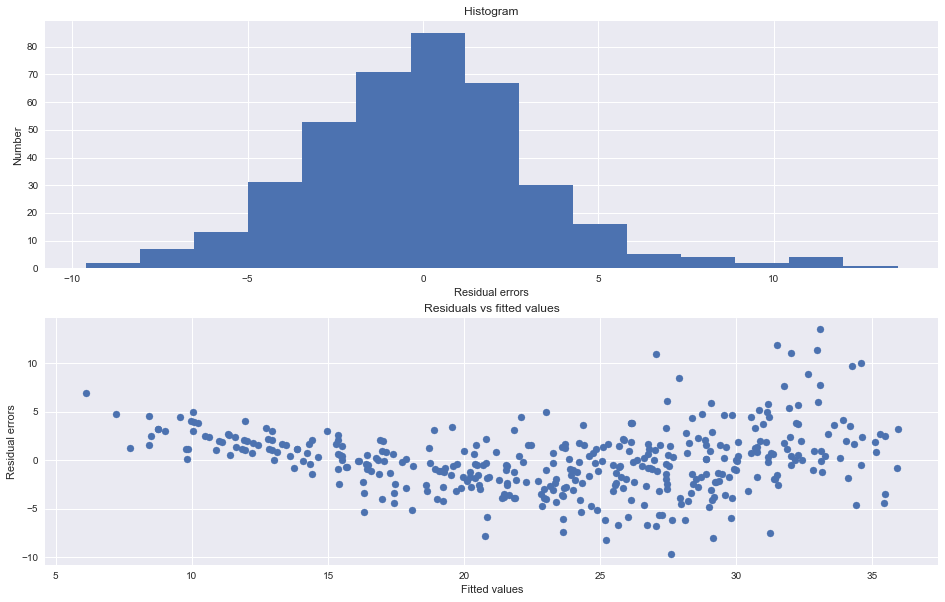

In [16]:
df4 = df_auto.drop('name', axis=1)
df4.corr()


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777151,-0.804841,-0.778253,-0.832590,0.421421,0.579165,0.568040
cylinders,-0.777151,1.000000,0.950770,0.842865,0.897820,-0.503332,-0.343537,-0.571436
displacement,-0.804841,0.950770,1.000000,0.897168,0.933166,-0.542940,-0.368343,-0.616673
horsepower,-0.778253,0.842865,0.897168,1.000000,0.864564,-0.689133,-0.415522,-0.456742
weight,-0.832590,0.897820,0.933166,0.864564,1.000000,-0.416847,-0.308945,-0.586016
acceleration,0.421421,-0.503332,-0.542940,-0.689133,-0.416847,1.000000,0.286153,0.215997
year,0.579165,-0.343537,-0.368343,-0.415522,-0.308945,0.286153,1.000000,0.185284
origin,0.568040,-0.571436,-0.616673,-0.456742,-0.586016,0.215997,0.185284,1.000000


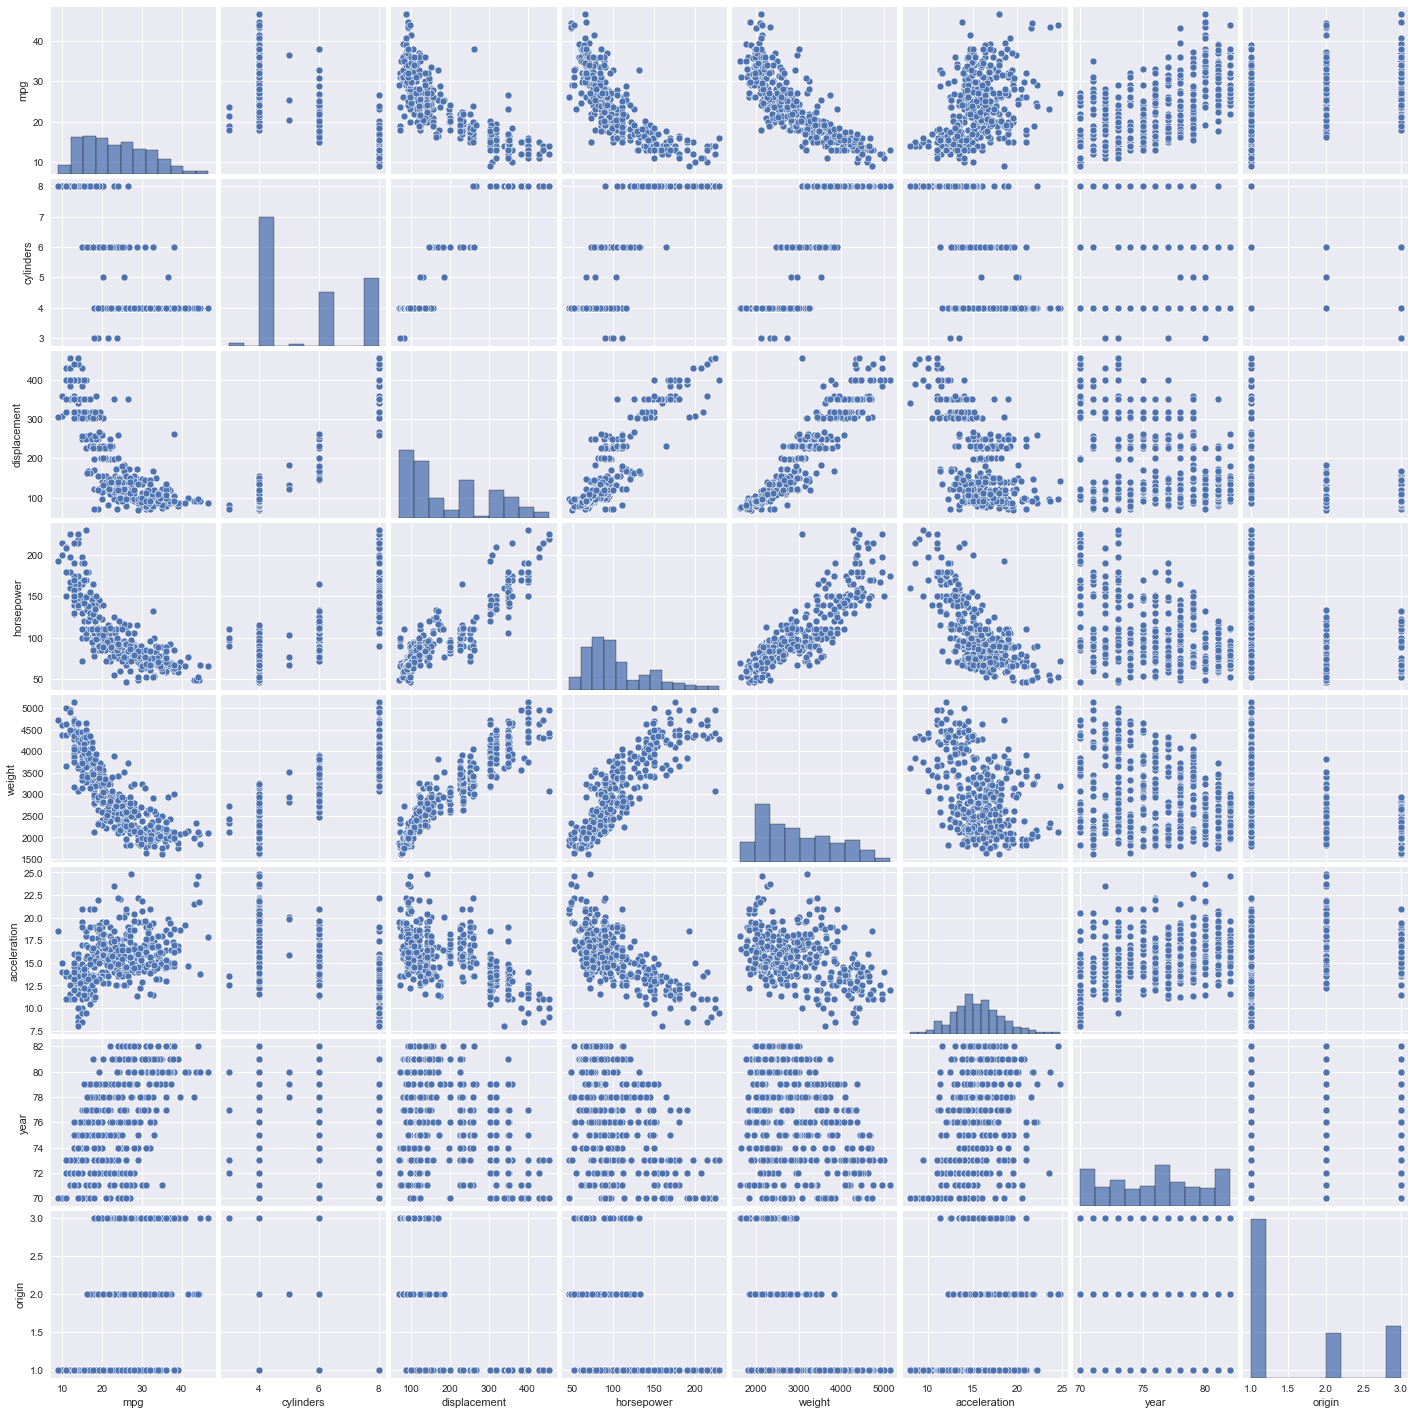

In [17]:
sns.pairplot(df4)

In [18]:
df4

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0
...,...,...,...,...,...,...,...,...
386,27.0,4.0,151.0,90.0,2950.0,17.3,82.0,1.0
387,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0
388,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0
389,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0


In [19]:
df_temp = pd.get_dummies(df4['origin'], drop_first=True)
df_temp =df_temp.rename(columns = {2.0 : '2', 3.0: '3'})

df4 = pd.merge(df4, df_temp, left_index=True, right_index=True)
df4 = df4.drop('origin', axis = 1)
df4

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,2,3
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,0,0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,0,0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,0,0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,0,0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,0,0
...,...,...,...,...,...,...,...,...,...
386,27.0,4.0,151.0,90.0,2950.0,17.3,82.0,0,0
387,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,0,0
388,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,1,0
389,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,0,0


In [20]:
df4.columns[-1]

'3'

In [21]:
#Scenario 1 includes all variables
#Variables: mpg', 'cylinders', 'displacement','horsepower','weight', 'acceleration','year', 2, 3

X = df4.drop('mpg', axis=1)
X = sm.add_constant(X)
y = df4[['mpg']]

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     216.7
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          6.78e-137
Time:                        20:29:10   Log-Likelihood:                -1018.0
No. Observations:                 391   AIC:                             2054.
Df Residuals:                     382   BIC:                             2090.
Df Model:                           8                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.6741      5.073     -3.484      0.000     -27.616      -7.732
cylinders       -0.4838      0.309     -1.567      0.117      -1.089       0.121
displacement     0.0242      0.009      2.749      0.006       0.007       0.041
horsepower      -0.0189      0.014     -1.314      0.189      -0.047       0.009
weight          -0.0067      0.001     -8.106      0.000      -0.008      -0.005
acceleration     0.0741      0.125      0.592      0.554      -0.171       0.320
year             0.7743      0.054     14.436      0.000       0.669       0.879
2                2.6596      0.655      4.062      0.000       1.376       3.943
3                2.8852      0.553      5.221      0.000       1.802       3.968
==============================================================================
Omnibus:                       23.849   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.238
Skew:                           0.451   Prob(JB):                     2.23e-08
Kurtosis:                       4.162   Cond. No.                     8.72e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 8.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
#Scenario 2 : Exclusion of variable : accelaration
variables = ['mpg', 'cylinders', 'displacement','horsepower', 'weight','year', '2', '3']
df4 = df4[variables]
X = df4.drop('mpg', axis = 1)
X = sm.add_constant(X)
y = df4[['mpg']]

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     245.8
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          2.06e-137
Time:                        20:29:10   Log-Likelihood:                -1018.3
No. Observations:                 391   AIC:                             2053.
Df Residuals:                     383   BIC:                             2084.
Df Model:                           7                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -16.1435      4.177     -3.865      0.000     -24.329      -7.958
cylinders       -0.4956      0.307     -1.612      0.107      -1.098       0.107
displacement     0.0236      0.008      2.796      0.005       0.007       0.040
horsepower      -0.0253      0.012     -2.046      0.041      -0.050      -0.001
weight          -0.0065      0.001    -10.282      0.000      -0.008      -0.005
year             0.7712      0.053     14.629      0.000       0.668       0.875
2                2.6657      0.662      4.030      0.000       1.369       3.962
3                2.8910      0.551      5.247      0.000       1.811       3.971
==============================================================================
Omnibus:                       26.271   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.428
Skew:                           0.474   Prob(JB):                     1.66e-09
Kurtosis:                       4.258   Cond. No.                     7.86e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 7.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
#Scenario 3 exclusion of variables : accelaration, 'cylinders'
variables = ['mpg', 'displacement','horsepower', 'weight','year', '2', '3']
df4 = df4[variables]
X = df4.drop('mpg', axis = 1)
X = sm.add_constant(X)
y = df4[['mpg']]

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     271.3
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          9.90e-135
Time:                        20:29:10   Log-Likelihood:                -1019.6
No. Observations:                 391   AIC:                             2053.
Df Residuals:                     384   BIC:                             2081.
Df Model:                           6                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2880      3.994     -4.328      0.000     -25.117      -9.459
displacement     0.0159      0.007      2.403      0.016       0.003       0.029
horsepower      -0.0234      0.012     -1.919      0.055      -0.047       0.000
weight          -0.0066      0.001    -10.616      0.000      -0.008      -0.005
year             0.7720      0.053     14.690      0.000       0.669       0.875
2                2.6291      0.662      3.971      0.000       1.331       3.927
3                2.8088      0.546      5.140      0.000       1.738       3.880
==============================================================================
Omnibus:                       25.072   Durbin-Watson:                   1.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.031
Skew:                           0.460   Prob(JB):                     5.52e-09
Kurtosis:                       4.219   Cond. No.                     7.74e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 7.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#Scenario 4 exclusion of variables : accelaration, 'cylinders','horsepower',
variables = ['mpg', 'displacement', 'weight','year', '2', '3']
df4 = df4[variables]
X = df4.drop('mpg', axis = 1)
X = sm.add_constant(X)
y = df4[['mpg']]

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     331.4
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          4.95e-137
Time:                        20:29:10   Log-Likelihood:                -1022.0
No. Observations:                 391   AIC:                             2056.
Df Residuals:                     385   BIC:                             2080.
Df Model:                           5                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -19.4278      4.158     -4.672      0.000     -27.578     -11.278
displacement     0.0096      0.006      1.676      0.094      -0.002       0.021
weight          -0.0068      0.001    -10.443      0.000      -0.008      -0.006
year             0.7957      0.055     14.454      0.000       0.688       0.904
2                2.4104      0.655      3.677      0.000       1.126       3.695
3                2.4667      0.541      4.559      0.000       1.406       3.527
==============================================================================
Omnibus:                       28.372   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.410
Skew:                           0.462   Prob(JB):                     1.87e-11
Kurtosis:                       4.476   Cond. No.                     7.52e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 7.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

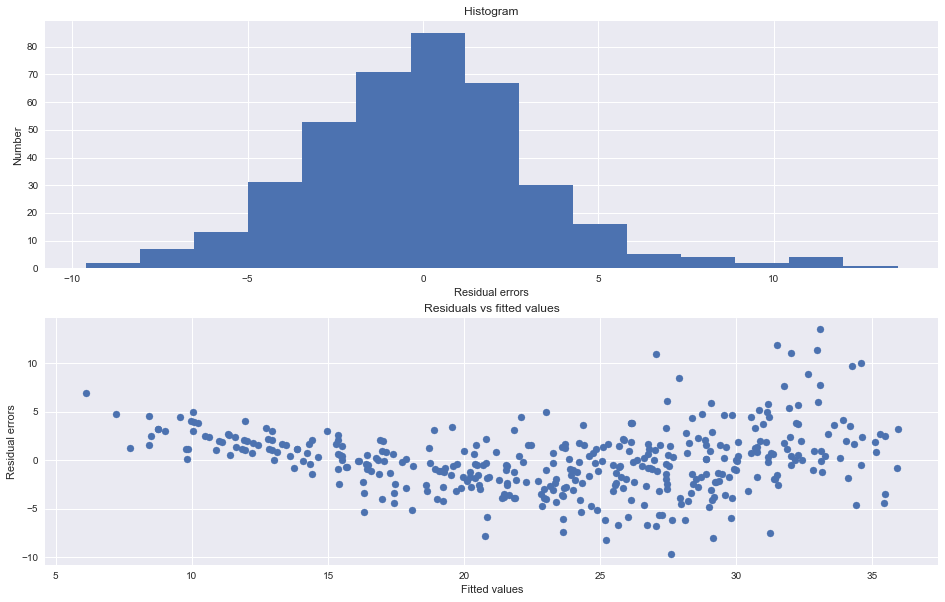

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     410.1
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          1.61e-137
Time:                        20:29:10   Log-Likelihood:                -1023.8
No. Observations:                 391   AIC:                             2058.
Df Residuals:                     386   BIC:                             2077.
Df Model:                           4                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.1363      4.026     -4.505      0.000     -26.027     -10.245
weight        -0.0059      0.000    -24.350      0.000      -0.006      -0.005
year           0.7673      0.050     15.224      0.000       0.668       0.866
2              1.9896      0.629      3.163      0.002       0.757       3.223
3              2.2333      0.566      3.948      0.000       1.125       3.342
==============================================================================
Omnibus:                       32.670   Durbin-Watson:                   1.250
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.992
Skew:                           0.512   Prob(JB):                     1.55e-13
Kurtosis:                       4.603   Cond. No.                     7.39e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 7.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
#Scenario 5 exclusion of variables : accelaration, 'cylinders','horsepower', displacement
variables = ['mpg', 'weight','year', '2', '3']
df4 = df4[variables]
X = df4.drop('mpg', axis = 1)
X = sm.add_constant(X)
y = df4[['mpg']]



est = sm.OLS(y, X).fit(cov_type='HC2')
xfit = np.array(X)
yfit = est.predict(xfit[:, np.newaxis])
fig, (ax1, ax2) = plt.subplots(2, figsize = (16,10))
ax1.hist(est.resid, bins=15)
ax1.set_xlabel('Residual errors')
ax1.set_ylabel('Number')
ax1.set_title('Histogram')
ax2.scatter(yfit, est.resid)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Residual errors')
ax2.set_title('Residuals vs fitted values')
plt.show()

est.summary()

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

Variables

- Sales
Unit sales (in thousands) at each location

- CompPrice
Price charged by competitor at each location

- Income
Community income level (in thousands of dollars)

- Advertising
Local advertising budget for company at each location (in thousands of dollars)

- Population
Population size in region (in thousands)

- Price
Price company charges for car seats at each site

- ShelveLoc
A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site

- Age
Average age of the local population

- Education
Education level at each location

- Urban
A factor with levels No and Yes to indicate whether the store is in an urban or rural location

- US
A factor with levels No and Yes to indicate whether the store is in the US or not

In [26]:
df_carseats = pd.read_csv('data/carseats.csv')
df5 = df_carseats.copy()
df5['Urban'] = df5['Urban'].map({'Yes' : 1, 'No' : 0 })
df5['US'] = df5['US'].map({'Yes' : 1, 'No' : 0 })
dummy_ShelveLoc = pd.get_dummies(df5['ShelveLoc'], drop_first=True)
df5 = pd.merge(df5 ,dummy_ShelveLoc, left_index = True, right_index = True).drop('ShelveLoc', axis =1)


In [29]:
#5.1
X = df5[['Price', 'Urban', 'US']]
y = df5[['Sales']]

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.809
Method:                 Least Squares   F-statistic:                              599.3
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                   5.66e-147
Time:                        20:29:34   Log-Likelihood:                         -1067.7
No. Observations:                 400   AIC:                                      2141.
Df Residuals:                     397   BIC:                                      2153.
Df Model:                           3                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price          0.0406      0.003     13.236      0.000       0.035       0.047
Urban          1.2917      0.384      3.365      0.001       0.539       2.044
US             2.1948      0.342      6.410      0.000       1.524       2.866
==============================================================================
Omnibus:                        1.426   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                1.214
Skew:                           0.121   Prob(JB):                        0.545
Kurtosis:                       3.120   Cond. No.                         260.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

5.2 Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

- If the store is located in the US then the store will sell around 2195 units more than a store located outside of the US. 
- If the store is located in an urban area then the store will sell around 1292 units more than a store located in a rural area. 
- For each additional dollar on the price, there will be an extra ~41 units sold. 

5.3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

The null hypothesis can be rejected for the following predictors: US, Urban and to a lesser extent Price


5.4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.


In [30]:
#5.4
X = df5[['Urban', 'US']]
y = df5[['Sales']]

est = sm.OLS(y, X).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Sales   R-squared (uncentered):                   0.731
Model:                            OLS   Adj. R-squared (uncentered):              0.730
Method:                 Least Squares   F-statistic:                              809.9
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                   5.13e-141
Time:                        20:29:37   Log-Likelihood:                         -1137.1
No. Observations:                 400   AIC:                                      2278.
Df Residuals:                     398   BIC:                                      2286.
Df Model:                           2                                                  
Covariance Type:                  HC2                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Urban          4.3459      0.316     13.765      0.000       3.727       4.965
US             4.7338      0.346     13.662      0.000       4.055       5.413
==============================================================================
Omnibus:                        2.020   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.364   Jarque-Bera (JB):                1.856
Skew:                           0.077   Prob(JB):                        0.395
Kurtosis:                       2.704   Cond. No.                         2.34
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC2)
"""

5.5 How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.
The model 1 fit the data better since the proportion of variance explained by the model 1 is greater than that of model 4.


5.6 Using the model from (5.4), obtain 95 % confidence intervals for the coefficient(s).

Unit sold = (4.3459 x Urban + 4.7338 x US)x1000

95% confidence interval: [4.055 x US + 3.727 x Urban , 5.413 x US + 4.965 x Urban]